In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import plac
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

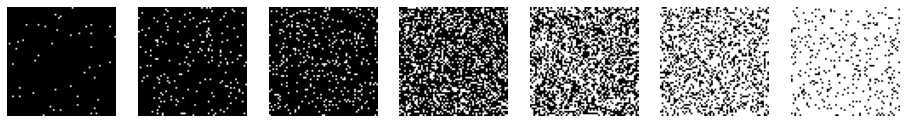

In [3]:
num_of_low_shots = 10
num_of_val = 24
image_size = 64

# given mask
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).type(dtype)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, image_size, image_size)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

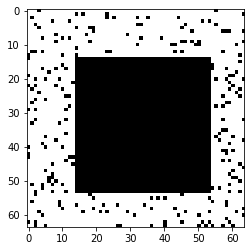

In [4]:
region_mask = torch.ones(image_size, image_size).type(dtype)
region_mask[14:54, 14:54] = 0
region_mask = region_mask.view(1, image_size, image_size)

combined_mask = region_mask * masks[6]
combined_mask_np = combined_mask.cpu().numpy()
plt.imshow(combined_mask_np.transpose(1, 2, 0))

In [5]:
# low shots
# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

random.seed(5)
img_lib = np.arange(45, len(data_set), 1)
random.shuffle(img_lib)
print(img_lib)

[158437 136381 157264 ... 194500  67008 163334]


In [6]:
train_set = IndexedDataset(torch.utils.data.Subset(data_set, img_lib[:num_of_low_shots]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate specific images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(27, 44, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [7]:
# dcgan
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
nz = 100

ngf = 64
nc = 3
ck = torch.load('./model_50final.pth')
dcg = Generator(ngpu).type(dtype)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    dcg = nn.DataParallel(dcg, list(range(ngpu)))
    
dcg.load_state_dict(ck['generator'])

z = np.random.normal(size=(1, nz, 1, 1)).astype(np.float32) / 10
z = torch.tensor(z).type(dtype)
z = Variable(z.type(dtype), requires_grad=True)

z_saved = torch.tensor(z.clone().data)
z_saved = Variable(z_saved.type(dtype), requires_grad=True)

for p in dcg.parameters():
    p.requires_grad_(False)

torch.Size([1, 3, 64, 64])


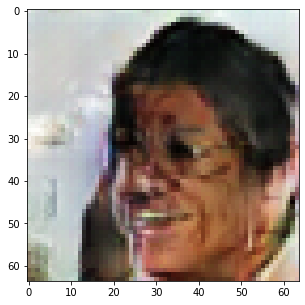

In [8]:
with torch.no_grad():
    out = dcg(z)

grid = torchvision.utils.make_grid(out.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(14, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
print(out.shape)

In [9]:
print(dcg)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
for p in dcg.parameters():
    print(p)

Parameter containing:
tensor([[[[ 3.2477e-03, -7.1013e-02,  4.8223e-02, -8.1134e-02],
          [-3.9739e-02, -3.1638e-02, -1.9997e-02, -8.0188e-02],
          [-4.6272e-02, -1.5361e-02,  3.9897e-02, -3.3362e-02],
          [ 1.7921e-02,  1.4920e-02,  5.7307e-03, -2.5000e-02]],

         [[-9.8466e-02, -1.7129e-02, -1.1595e-01,  6.6653e-03],
          [-3.5652e-02, -1.0592e-02, -4.2974e-02,  2.5203e-02],
          [-2.1691e-02,  5.8600e-02, -3.1848e-02,  2.5188e-02],
          [ 7.2016e-02,  6.0981e-02, -3.1236e-02, -1.8347e-02]],

         [[-3.6859e-02,  1.0402e-01,  1.3575e-02, -1.4073e-02],
          [ 6.1544e-03,  3.3541e-02, -3.1136e-02, -1.6110e-03],
          [ 3.3142e-02,  2.1963e-02, -4.3508e-03, -2.1869e-02],
          [ 1.9528e-02,  5.5704e-02, -3.8759e-02, -1.3028e-04]],

         ...,

         [[ 2.6300e-03, -1.2522e-02, -1.4009e-02, -3.2883e-02],
          [ 5.6161e-03,  4.6725e-02,  2.2867e-02,  2.1236e-02],
          [-5.0872e-02,  2.8182e-03, -4.4791e-03, -2.1946e-02

In [11]:
# deep decoder
k = 64
num_channels = [k]*2
dd = fixed_decodernw(num_channels_up=num_channels, upsample_mode='bilinear').type(dtype)
print(dd)

Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (3): Upsample(scale_factor=2.0, mode=bilinear)
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (7): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (8): Upsample(scale_factor=2.0, mode=bilinear)
  (9): ReLU()
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sequential(
    (0): ReflectionPad2d((1, 0, 1, 0))
    (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), paddi

In [12]:
# deep decoder fixed input: y
totalupsample = 2**len(num_channels)
width = int(image_size/totalupsample)
height = int(image_size/totalupsample)
shape = [1,num_channels[0], width, height]
print("shape: ", shape)
y = Variable(torch.zeros(shape))
y.data.uniform_()
y.data *= 1./10

y = y.type(dtype)
y_saved = y.data.clone()

shape:  [1, 64, 16, 16]


In [13]:
def train_dcgan_dd(n_epochs, 
                   img_noisy_var,
                   dcg, 
                   z,
                   dd, 
                   y,
                   dtype, # which device
                   mask=None, # inpainting
                   measure=None, # compressive sensing
                   active=None
                  ):
    dcg.train()
    dd.train()
    
    # prepare optimizer
    if active is None:
        print('train dcgan, dd')
        optimizer = torch.optim.Adam([
                {'params': [z]}, # input of dcgan
                {'params': dd.parameters(), 'lr': 0.015} # parameters of deep decoder
            ], lr=0.005)
    elif active == 'dcgan':
        print('train dcgan, fix parameters of dd')
        for p in dd.parameters():
            p.requires_grad_(False)
            
        optimizer = torch.optim.Adam([
                {'params': [z]}, # input of dcgan
            ], lr=0.005)
    elif active == 'dd':
        print('train dd, fix dcgan')
        z.requires_grad_(False)
        optimizer = torch.optim.Adam([
                {'params': dd.parameters()} # parameters of deep decoder
            ], lr=0.015)
         
    
    # training..
    for epoch in range(1, n_epochs+1):
        losses = []
#         progress = tqdm(total=1, desc='epoch % 3d' % epoch) # for one target image
        G_z = dcg(z) + dd(y)
        G_z = G_z / 2 + 0.5 
#         G_z = dd(y) / 2 + 0.5

        if mask != None:
            loss = loss_fn(G_z * mask, img_noisy_var)
#         elif measure != None:
#             def forwardm(img_var):
#                 X = img_var.reshape(-1, np.prod(img_var.shape))
#                 return torch.mm(X, measure)  
            
#             loss = loss_fn(forwardm(G_z), img_noisy_var) # compressive sensing
        else:
            loss = loss_fn(G_z, img_noisy_var)
              
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 1000 == 0:
            print('epoch: {} \t average loss: {:.8f}'.format(epoch, np.mean(losses[-199:])))
#         progress.set_postfix({'loss': np.mean(losses[-99:])})
#         progress.update()
#         progress.close()
 
    # restore
    z.requires_grad_(True)
    for p in dd.parameters():
        p.requires_grad_(True)
    
    return z, G_z

In [14]:
# mask = masks[0].type(dtype)
mask = combined_mask
for img_clean_var, _, img_list in val_loader:
    img_clean_var = Variable(img_clean_var).type(dtype)
    img_noisy_var = (img_clean_var * mask).type(dtype)
    z, _ = train_dcgan_dd(8000, img_noisy_var, dcg, z, dd, y, dtype=dtype, mask=mask, active='dcgan')
    z_, G_z_ = train_dcgan_dd(12000, img_noisy_var, dcg, z, dd, y, dtype=dtype, mask=mask, active='dd')
#     z_, G_z_ = train_dcgan_dd(13000, img_noisy_var, dcg, z, dd, y, dtype=dtype, mask=mask)
    break

train dcgan, fix parameters of dd
epoch: 1000 	 average loss: 0.02545854
epoch: 2000 	 average loss: 0.02501602
epoch: 3000 	 average loss: 0.02456987
epoch: 4000 	 average loss: 0.02446008
epoch: 5000 	 average loss: 0.02435234
epoch: 6000 	 average loss: 0.02428628
epoch: 7000 	 average loss: 0.02423722
epoch: 8000 	 average loss: 0.02358602
train dd, fix dcgan
epoch: 1000 	 average loss: 0.00009090
epoch: 2000 	 average loss: 0.00002490
epoch: 3000 	 average loss: 0.00001007
epoch: 4000 	 average loss: 0.00000821
epoch: 5000 	 average loss: 0.00005992
epoch: 6000 	 average loss: 0.00000982
epoch: 7000 	 average loss: 0.00000214
epoch: 8000 	 average loss: 0.00002252
epoch: 9000 	 average loss: 0.00001473
epoch: 10000 	 average loss: 0.00001030
epoch: 11000 	 average loss: 0.00000309
epoch: 12000 	 average loss: 0.00000724


(-0.5, 63.5, 63.5, -0.5)

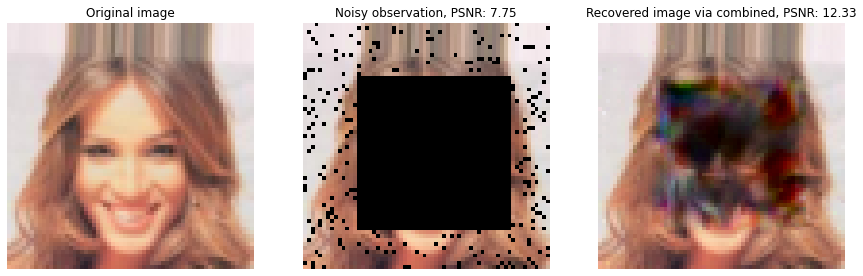

In [15]:
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

fig = plt.figure(figsize = (15,15)) 

ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var)
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), (img_noisy_var.cpu().numpy() * mask.cpu().numpy())))
ax2.axis('off')

ax3 = fig.add_subplot(133)
myimgshow(ax3, G_z_)
ax3.set_title( "Recovered image via combined, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), G_z_.detach().cpu().numpy()) ) 
ax3.axis('off')

In [17]:
# naive deep-decoder 1
numit = 10000
num_channels = [k]*3

net = fixed_decodernw(num_channels_up=num_channels, upsample_mode='bilinear').type(dtype)
mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        num_iter=numit,
                        LR=0.015,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask,
                        find_best=False,
                        upsample_mode='bilinear'
                        )

final_output = net( ni.type(dtype) ).detach()

input shape:  [1, 64, 8, 8]
optimize with adam 0.015


(-0.5, 63.5, 63.5, -0.5)

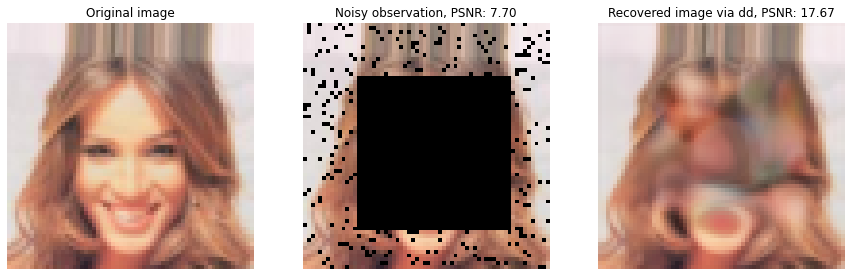

In [18]:
fig = plt.figure(figsize = (15,15)) 

ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var)
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), (img_noisy_var.cpu().numpy() * mask.cpu().numpy())))
ax2.axis('off')

ax3 = fig.add_subplot(133)
myimgshow(ax3, final_output/2 + 0.5)
ax3.set_title( "Recovered image via dd, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), (final_output/2 + 0.5).detach().cpu().numpy()) ) 
ax3.axis('off')

In [13]:
# train only via dcgan
def train_dcgan(n_epochs, 
                   img_noisy_var,
                   dcg, 
                   z,
                   dtype, # which device
                   mask=None, # inpainting
                   measure=None, # compressive sensing
                   active=None
                  ):
    dcg.train()
    print('train dcgan, fix parameters of dd')
    optimizer = torch.optim.Adam([
            {'params': [z]}, # input of dcgan
        ], lr=0.001)
    
    # training..
    for epoch in range(1, n_epochs+1):
        losses = []
#         progress = tqdm(total=1, desc='epoch % 3d' % epoch) # for one target image
        G_z = dcg(z) / 2 + 0.5 
    
        if mask != None:
            loss = loss_fn(G_z * mask, img_noisy_var) + 0.001 * torch.norm(z)**2
#         elif measure != None:
#             def forwardm(img_var):
#                 X = img_var.reshape(-1, np.prod(img_var.shape))
#                 return torch.mm(X, measure)  
            
#             loss = loss_fn(forwardm(G_z), img_noisy_var) # compressive sensing
        else:
            loss = loss_fn(G_z, img_noisy_var)
              
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 1000 == 0:
            print('epoch: {} \t average loss: {:.8f}'.format(epoch, np.mean(losses[-199:])))
#         progress.set_postfix({'loss': np.mean(losses[-99:])})
#         progress.update()
#         progress.close()
    return z, G_z

In [14]:
# mask = masks[0].type(dtype)
mask = combined_mask
for img_clean_var, _, img_list in val_loader:
    img_clean_var = Variable(img_clean_var).type(dtype)
    img_noisy_var = (img_clean_var * mask).type(dtype)
    z_, G_z_ = train_dcgan(13000, img_noisy_var, dcg, z_saved, dtype=dtype, mask=mask)
    break

train dcgan, fix parameters of dd
epoch: 1000 	 average loss: 0.00516042
epoch: 2000 	 average loss: 0.00416716
epoch: 3000 	 average loss: 0.00401683
epoch: 4000 	 average loss: 0.00401516
epoch: 5000 	 average loss: 0.00400650
epoch: 6000 	 average loss: 0.00401396
epoch: 7000 	 average loss: 0.00400097
epoch: 8000 	 average loss: 0.00399491
epoch: 9000 	 average loss: 0.00399341
epoch: 10000 	 average loss: 0.00398943
epoch: 11000 	 average loss: 0.00398974
epoch: 12000 	 average loss: 0.00399668
epoch: 13000 	 average loss: 0.00400957


(-0.5, 63.5, 63.5, -0.5)

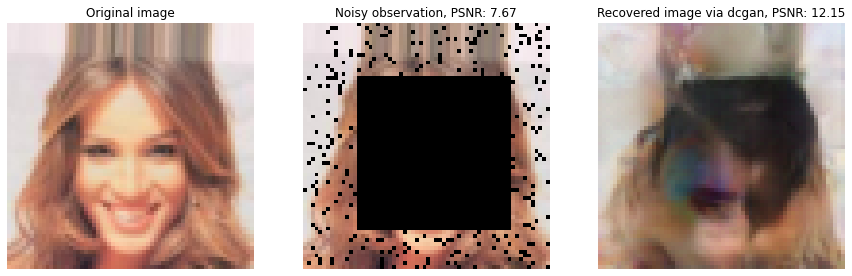

In [16]:
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

fig = plt.figure(figsize = (15,15)) 

ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var)
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), (img_noisy_var.cpu().numpy() * mask.cpu().numpy())))
ax2.axis('off')

ax3 = fig.add_subplot(133)
myimgshow(ax3, G_z_)
ax3.set_title( "Recovered image via dcgan, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), (G_z_).detach().cpu().numpy()) ) 
ax3.axis('off')